In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names\Arabic.txt
data/names\Chinese.txt
data/names\Czech.txt
data/names\Dutch.txt
data/names\English.txt
data/names\French.txt
data/names\German.txt
data/names\Greek.txt
data/names\Irish.txt
data/names\Italian.txt
data/names\Japanese.txt
data/names\Korean.txt
data/names\Polish.txt
data/names\Portuguese.txt
data/names\Russian.txt
data/names\Scottish.txt
data/names\Spanish.txt
data/names\Vietnamese.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbas,English
1,Abbey,English
2,Abbott,English
3,Abdi,English
4,Abel,English


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [11]:
test_split = 0.2
from sklearn.model_selection import train_test_split

### START YOUR CODE
# Shuffle and split names data into train and test
train, test = train_test_split(names, test_size=test_split, random_state=42)

print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")
### END YOUR CODE

Training data size: 4540
Testing data size: 1136


In [14]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)
def transform_data(df, maxlen, char_index, language_to_index):
    X = np.zeros((len(df), maxlen, len(char_index)), dtype=np.float32) # create a matrix of zeros with the shape of the data --> optional but still interesting
    Y = np.zeros((len(df), len(language_to_index)), dtype=np.float32)
    
    for idx, (index, row) in enumerate(df.iterrows()):
        X[idx] = name_representation(row['name'], maxlen) # use fonctions above --> i think the functions are correct
        Y[idx] = lang_representation(row['lang'], language_to_index) # same for here 
    
    return X, Y

train.reset_index(drop=True, inplace=True) # reset index to avoid problems
test.reset_index(drop=True, inplace=True) # reset index to avoid problems

X_train, Y_train = transform_data(train, maxlen, char_index, language_to_index)
X_test, Y_test = transform_data(test, maxlen, char_index, language_to_index)
### END YOUR CODE

In [15]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (4540, 18, 74)
Y_train shape: (4540, 5)
X_test shape: (1136, 18, 74)
Y_test shape: (1136, 5)


### Utilities

In [16]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [17]:
import sklearn
import pandas as pd

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [19]:
### START YOUR CODE
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential

# SImpleRNN, single layer with tf.keras....

model = Sequential([
    SimpleRNN(units=128, input_shape=(maxlen, len(char_index)), activation='tanh'),
    Dense(len(language_to_index), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

### END YOUR CODE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 128)               25984     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 26629 (104.02 KB)
Trainable params: 26629 (104.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
### START YOUR CODE
batch_size= 64
nepochs = 10
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))


### END YOUR CODE

Epoch 1/10
71/71 [==============================] - 2s 9ms/step - loss: 0.9974 - accuracy: 0.6716 - val_loss: 0.9021 - val_accuracy: 0.6831
Epoch 2/10
71/71 [==============================] - 0s 5ms/step - loss: 0.7918 - accuracy: 0.7216 - val_loss: 0.7773 - val_accuracy: 0.6998
Epoch 3/10
71/71 [==============================] - 0s 5ms/step - loss: 0.7277 - accuracy: 0.7339 - val_loss: 0.7638 - val_accuracy: 0.7368
Epoch 4/10
71/71 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.7509 - val_loss: 0.7041 - val_accuracy: 0.7465
Epoch 5/10
71/71 [==============================] - 0s 5ms/step - loss: 0.6538 - accuracy: 0.7676 - val_loss: 0.7127 - val_accuracy: 0.7430
Epoch 6/10
71/71 [==============================] - 0s 5ms/step - loss: 0.6349 - accuracy: 0.7685 - val_loss: 0.7194 - val_accuracy: 0.7245
Epoch 7/10
71/71 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.7804 - val_loss: 0.6621 - val_accuracy: 0.7553
Epoch 8/10
71/71 [==

Train accuracy (end): 0.8068282008171082
Train accuracy (max): 0.8068282008171082
Test accuracy (end) : 0.7658450603485107
Test accuracy (max) : 0.7658450603485107


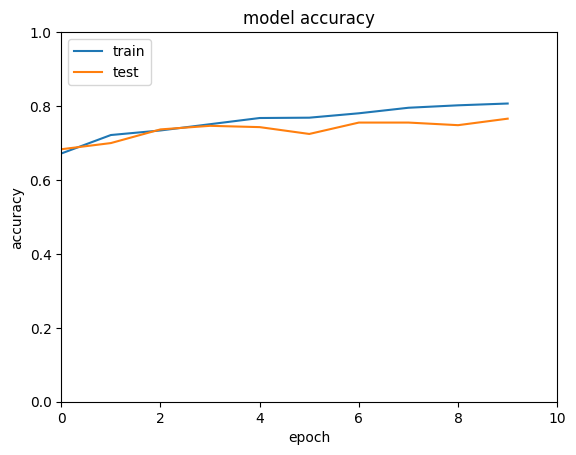

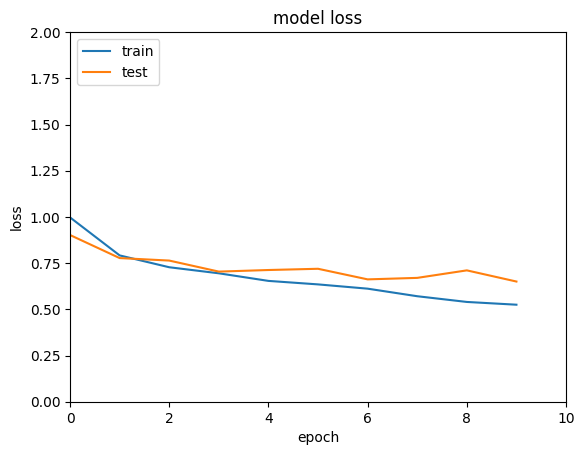

36/36 [==============================] - 0s 2ms/step


,English,French,Italian,German,Spanish
English,663,3,28,21,9
French,33,5,9,13,1
Italian,59,4,78,3,3
German,18,4,1,107,15
Spanish,12,2,4,24,17


In [22]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [23]:
def handle_imbalance(names, languages):
    max_size = names['lang'].value_counts().max() # take largest clas
    names_upsampled = pd.DataFrame()

    for language in languages:
        names_lang = names[names['lang'] == language]
        names_resampled = names_lang.sample(n=max_size, replace=True, random_state=42)
        names_upsampled = pd.concat([names_upsampled, names_resampled], axis=0)

    names_upsampled = names_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return names_upsampled


In [24]:
names_upsampled = handle_imbalance(names, languages)
names_upsampled.groupby('lang')['name'].count()/len(names_upsampled)

lang
English    0.2
French     0.2
German     0.2
Italian    0.2
Spanish    0.2
Name: name, dtype: float64

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [25]:
### START YOUR CODE

train_resampled, test_resampled = train_test_split(names_upsampled, test_size=0.2, random_state=42)

X_train, Y_train = transform_data(train_resampled, maxlen, char_index, language_to_index)
X_test, Y_test = transform_data(test_resampled, maxlen, char_index, language_to_index)

### END YOUR CODE

In [27]:
### START YOUR CODE

# train model

batch_size = 64
nepochs = 10

log2 = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1191 - accuracy: 0.9584 - val_loss: 0.1717 - val_accuracy: 0.9433
Epoch 2/10
230/230 [==============================] - 1s 5ms/step - loss: 0.1124 - accuracy: 0.9603 - val_loss: 0.1711 - val_accuracy: 0.9389
Epoch 3/10
230/230 [==============================] - 1s 5ms/step - loss: 0.1215 - accuracy: 0.9564 - val_loss: 0.1867 - val_accuracy: 0.9427
Epoch 4/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1123 - accuracy: 0.9609 - val_loss: 0.1952 - val_accuracy: 0.9387
Epoch 5/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1237 - accuracy: 0.9554 - val_loss: 0.1820 - val_accuracy: 0.9381
Epoch 6/10
230/230 [==============================] - 1s 6ms/step - loss: 0.1031 - accuracy: 0.9625 - val_loss: 0.1750 - val_accuracy: 0.9381
Epoch 7/10
230/230 [==============================] - 1s 5ms/step - loss: 0.1036 - accuracy: 0.9614 - val_loss: 0.1639 - val_accuracy: 0.9452
Epoch 

Train accuracy (end): 0.9563794732093811
Train accuracy (max): 0.9625136256217957
Test accuracy (end) : 0.9370229244232178
Test accuracy (max) : 0.9452017545700073


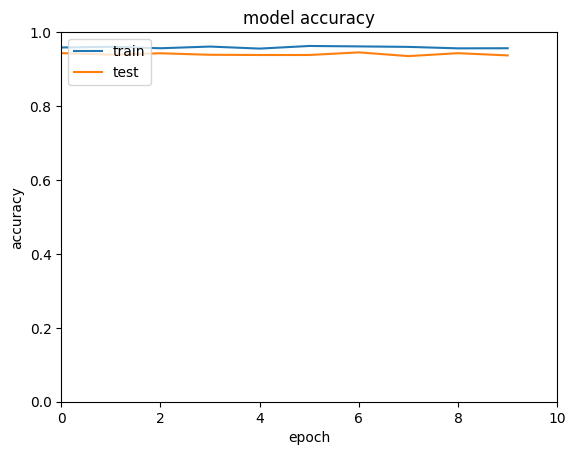

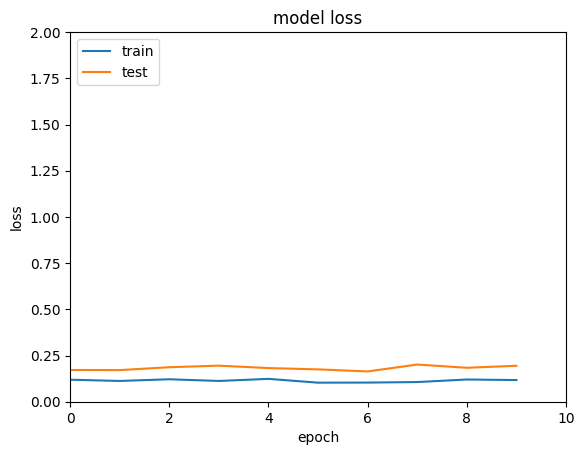

115/115 [==============================] - 0s 2ms/step


,English,French,Italian,German,Spanish
English,636,46,27,20,9
French,5,725,3,3,8
Italian,21,16,692,1,4
German,0,0,1,708,22
Spanish,7,12,0,26,676


In [28]:
performance_plots(model, X_test, Y_test, log2, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

The results with the balanced data show significant improvements compared to the unbalanced data. The training accuracy at the end of training is about 95.64%. The accuracy on the test data at the end also increased to about 93.70%, with a peak accuracy of 94.52%. This shows that balancing the data helped the model to learn more effectively and perform better on new, unseen data. Overall, the model has become more reliable and fair in predicting the language from names across all classes.

The confusion matrix of for the model trained with balanced data demonstrates strong performance, with most predictions correctly identifying the language of names. The matrix shows that the majority of names for each language are classified correctly, which demonstrates that the model is effective at distinguishing between the languages. While there are some misclassifications where names are incorrectly predicted as a different language, these errors are relatively few compared to the correct predictions. This suggests that the model is quite robust and reliable, handling the complexities of language-specific names well across all tested categories. Compare to the other results of the unbalanced data, the model trained with balanced data has a much better performance and is more reliable in predicting the language of names (as said before).




#### In which situations is class imbalance treatment important and why?  

Class imbalance treatment is crucial in scenarios where the data does not equally represent all categories or classes. This often occurs in fields such as medical diagnostics, fraud detection, and sentiment analysis, where certain outcomes are much rarer than others. Without addressing class imbalance, machine learning or deep learning models like in this noitebook models can develop a bias towards the more frequent classes, leading to poor generalization when predicting less common classes. This can result in higher misclassification rates for those minority classes, which might be the most critical to detect accurately. When we treat this problem, we ensure that the model does not only learn to predict the majority class, but rather learns to recognize the distinguishing features of all classes, improving its overall accuracy and performance. This is particularly important in applications where the cost of misclassification is high.

Source : https://www.sciencedirect.com/topics/computer-science/class-imbalance-problem#:~:text=The%20class%20imbalance%20problem%20typically,and%20ignore%20the%20small%20ones.


### Implement Model with several SimpleRNN Layers

In [31]:
### START YOUR CODE

model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(maxlen, len(char_index)), activation='tanh'),
    SimpleRNN(64, return_sequences=True, activation='tanh'),
    SimpleRNN(64, return_sequences=False, activation='tanh'),
    Dense(len(language_to_index), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 18, 64)            8896      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 18, 64)            8256      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 25733 (100.52 KB)
Trainable params: 25733 (100.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
### START YOUR CODE

batch_size = 64
nepochs = 10

log3 = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/10
230/230 [==============================] - 5s 10ms/step - loss: 1.0772 - accuracy: 0.5599 - val_loss: 0.7304 - val_accuracy: 0.7214
Epoch 2/10
230/230 [==============================] - 2s 9ms/step - loss: 0.6435 - accuracy: 0.7584 - val_loss: 0.5462 - val_accuracy: 0.7991
Epoch 3/10
230/230 [==============================] - 2s 9ms/step - loss: 0.4431 - accuracy: 0.8413 - val_loss: 0.3867 - val_accuracy: 0.8621
Epoch 4/10
230/230 [==============================] - 2s 10ms/step - loss: 0.3259 - accuracy: 0.8870 - val_loss: 0.3401 - val_accuracy: 0.8836
Epoch 5/10
230/230 [==============================] - 2s 8ms/step - loss: 0.2676 - accuracy: 0.9123 - val_loss: 0.3104 - val_accuracy: 0.8926
Epoch 6/10
230/230 [==============================] - 2s 8ms/step - loss: 0.2310 - accuracy: 0.9224 - val_loss: 0.2685 - val_accuracy: 0.9103
Epoch 7/10
230/230 [==============================] - 2s 9ms/step - loss: 0.2061 - accuracy: 0.9325 - val_loss: 0.2495 - val_accuracy: 0.9125
Epoc

Train accuracy (end): 0.9460877776145935
Train accuracy (max): 0.9460877776145935
Test accuracy (end) : 0.9318429827690125
Test accuracy (max) : 0.9318429827690125


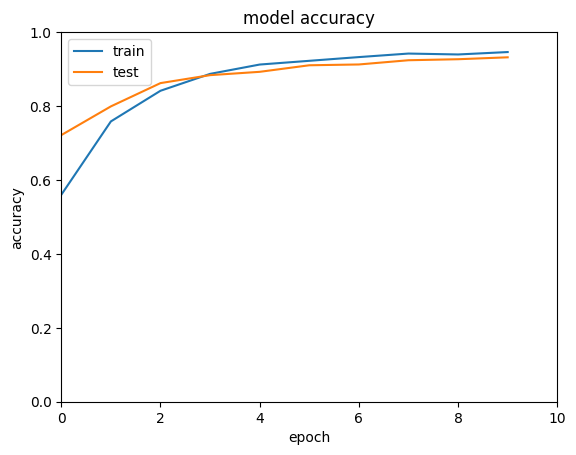

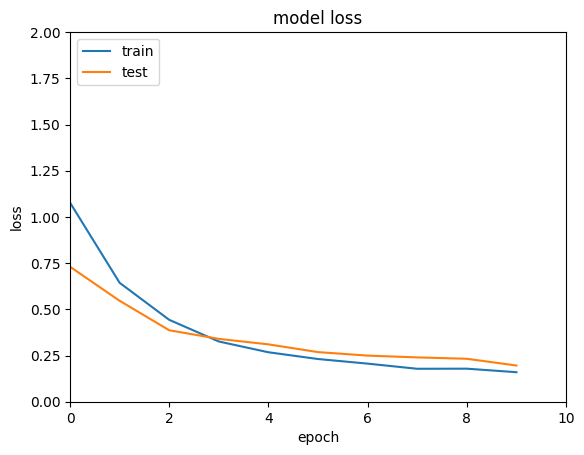

115/115 [==============================] - 1s 3ms/step


,English,French,Italian,German,Spanish
English,632,38,41,20,7
French,4,722,11,0,7
Italian,42,12,676,0,4
German,4,1,0,695,31
Spanish,1,16,0,11,693


In [33]:
performance_plots(model, X_test, Y_test, log3, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

The significant difference compared to the other score obtained is that the model with multiple SimpleRNN layers has a score equal to the one with a single RNN layer. This shows that the model with multiple layers did not improve the performance. This could be due to several reasons, including the fact that the simple model was already complex enough to learn the data and adding additional layers did not enhance performance. Generally, it is important to test different model architectures to find the one that works best for the specific data, and we see that in our case, the model with a single SimpleRNN layer provided good results as much as the one with multiple layers.

One important thing to note is that the single-layer model starts directly with a very high score and remains stable throughout, unlike the model with multiple layers, which starts with a lower score and then increases. This could be due to the fact that the model with multiple layers is more complex and therefore takes longer to learn the data. However, in the end, the performance is similar to the single-layer model, which suggests that the additional complexity did not provide any significant benefits in this case.
